
# Under-sampling Method Comparison
Machine Learning with Imbalanced Data - Course

We will compare how the different under-sampling algorithms discussed in this section improve (or not) the performance of Random Forests on different datasets with imbalanced classes.

## Important
* We train the models on a portion of the data that is under-sampled
* We evaluate the model performance on another portion of the data that was not resampled, and thus contains the original class distribution.

In [2]:
from collections import Counter

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from imblearn.datasets import fetch_datasets

from imblearn.under_sampling import(
    RandomUnderSampler,
    CondensedNearestNeighbour,
    TomekLinks,
    OneSidedSelection,
    EditedNearestNeighbours,
    RepeatedEditedNearestNeighbours,
    AllKNN,
    NeighbourhoodCleaningRule,
    NearMiss,
    InstanceHardnessThreshold,
)

In [3]:
undersampler_dict = {
    'random': RandomUnderSampler(
        sampling_strategy='auto',
        random_state=0,
        replacement=False,
    ),

    'cnn': CondensedNearestNeighbour(
        sampling_strategy='auto',
        random_state=0,
        n_neighbors=1,
        n_jobs=-1,
    ),

    'tomek': TomekLinks(
        sampling_strategy='auto',
        n_jobs=-1,
    ),

    'oss': OneSidedSelection(
        sampling_strategy='auto',
        random_state=0,
        n_neighbors=1,
        n_jobs=-1,
    ),

    'enn': EditedNearestNeighbours(
        sampling_strategy='auto',
        n_neighbors=3,
        kind_sel='all',
        n_jobs=-1,
    ),

    'renn': RepeatedEditedNearestNeighbours(
        sampling_strategy='auto',
        n_neighbors=3,
        kind_sel='all',
        n_jobs=-1,
        max_iter=100,
    ),

    'allknn': AllKNN(
        sampling_strategy='auto',
        n_neighbors=3,
        kind_sel='all',
        n_jobs=-1,
    ),

    'ncr': NeighbourhoodCleaningRule(
        sampling_strategy='auto',
        n_neighbors=3,
        kind_sel='all',
        n_jobs=-1,
        threshold_cleaning=0.5,
    ),

    'nm1': NearMiss(
        sampling_strategy='auto',
        version=1,
        n_neighbors=3,
        n_jobs=-1,
    ),

    'nm2': NearMiss(
        sampling_strategy='auto',
        version=2,
        n_neighbors=3,
        n_jobs=-1
    ),

    # here I set up a Logistic regression but remember
    # that the authors of this technique concluded that it is best
    # to use the same classifier that will be used to train the final
    # model, so in our case, we should have used a Random Forest
    'iht': InstanceHardnessThreshold(
        estimator=LogisticRegression(random_state=0),
        sampling_strategy='auto',
        random_state=0,
        n_jobs=4,
        cv=3),
}

In [4]:
dataset_ls = [
    'car_eval_34',
    'ecoli',
    'thyroid_sick',
    'arrhythmia',
    'ozone_level',
]

In [5]:
# print class imbalance for each dataset
# this is to get a tiny bit familiar with the datasets
for dataset in dataset_ls:
    data = fetch_datasets()[dataset]
    print(dataset)
    print(Counter(data.target))
    print()

car_eval_34
Counter({-1: 1594, 1: 134})

ecoli
Counter({-1: 301, 1: 35})

thyroid_sick
Counter({-1: 3541, 1: 231})

arrhythmia
Counter({-1: 427, 1: 25})

ozone_level
Counter({-1: 2463, 1: 73})



In [6]:
# function to train random forests and evaluate the performance

def run_randomForests(X_train, X_test, y_train, y_test):

    rf = RandomForestClassifier(
        n_estimators=100, random_state=39, max_depth=3, n_jobs=4,
    )
    
    rf.fit(X_train, y_train)

    print('Train set')
    pred = rf.predict_proba(X_train)
    print(
        'Random Forests roc-auc: {}'.format(roc_auc_score(y_train, pred[:, 1])))

    print('Test set')
    pred = rf.predict_proba(X_test)
    print(
        'Random Forests roc-auc: {}'.format(roc_auc_score(y_test, pred[:, 1])))
    
    # NOTE: that this function returns the ROC over the test set
    # which is the portion of the data that would not be under-sampled
    return roc_auc_score(y_test, pred[:, 1])

In [8]:
# loop to train models with different undersampling methods
# over the different datasets

# save the results
results_dict = {}
shapes_dict = {}

# for each dataset
for dataset in dataset_ls:
    # start a new dictionary per dataset
    results_dict[dataset] = {}
    shapes_dict[dataset] = {}

    print(dataset)

    # separate train and test
    X_train, X_test, y_train, y_test = train_test_split(
        data.data,  
        data.target, 
        test_size=0.3,
        random_state=0,
    )

    # as many undersampling techniques use KNN 
    # we put the variables in the same scale
    scaler = MinMaxScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    # train a model on the original dataset without undersampling
    # and determine model performance
    roc = run_randomForests(X_train, X_test, y_train, y_test)

    # store results
    results_dict[dataset]['full_data'] = roc
    shapes_dict[dataset]['full_data'] = len(X_train)

    print()

    # now we test the different undersamplers
    for undersampler in undersampler_dict:
        print(undersampler)

        # resample the train set only
        X_resampled, y_resampled = undersampler_dict[undersampler].fit_resample(X_train, y_train)

        # train model and evaluate performance
        # note the performance returned is using the test set, which was not undersampled
        roc = run_randomForests(X_resampled, X_test, y_resampled, y_test)

        # store results
        results_dict[dataset][undersampler] = roc
        shapes_dict[dataset][undersampler] = len(X_resampled)
        print()

    print()    

car_eval_34
Train set
Random Forests roc-auc: 0.9730903165319881
Test set
Random Forests roc-auc: 0.826061776061776

random
Train set
Random Forests roc-auc: 0.9892751479289941
Test set
Random Forests roc-auc: 0.8254826254826255

cnn
Train set
Random Forests roc-auc: 0.9530956848030019
Test set
Random Forests roc-auc: 0.8268339768339769

tomek
Train set
Random Forests roc-auc: 0.9601231128684399
Test set
Random Forests roc-auc: 0.8096525096525096

oss
Train set
Random Forests roc-auc: 0.957703304558201
Test set
Random Forests roc-auc: 0.7922779922779922

enn
Train set
Random Forests roc-auc: 0.9664294554455445
Test set
Random Forests roc-auc: 0.834041184041184

renn
Train set
Random Forests roc-auc: 0.9762014675154284
Test set
Random Forests roc-auc: 0.8323037323037322

allknn
Train set
Random Forests roc-auc: 0.9764543269230769
Test set
Random Forests roc-auc: 0.8305662805662806

ncr


c:\Users\Asus\AppData\Local\Programs\Python\Python39\lib\site-packages\imblearn\under_sampling\_prototype_selection\_neighbourhood_cleaning_rule.py:201: FutureWarning: `kind_sel` is deprecated in 0.12 and will be removed in 0.14. It already has not effect and corresponds to the `'all'` option.
  warnings.warn(


Train set
Random Forests roc-auc: 0.9736432279377065
Test set
Random Forests roc-auc: 0.8160231660231659

nm1
Train set
Random Forests roc-auc: 0.9774408284023668
Test set
Random Forests roc-auc: 0.5876447876447877

nm2
Train set
Random Forests roc-auc: 0.9985207100591715
Test set
Random Forests roc-auc: 0.8113899613899613

iht
Train set
Random Forests roc-auc: 0.988905325443787
Test set
Random Forests roc-auc: 0.4562419562419563


ecoli
Train set
Random Forests roc-auc: 0.9730903165319881
Test set
Random Forests roc-auc: 0.826061776061776

random
Train set
Random Forests roc-auc: 0.9892751479289941
Test set
Random Forests roc-auc: 0.8254826254826255

cnn
Train set
Random Forests roc-auc: 0.9530956848030019
Test set
Random Forests roc-auc: 0.8268339768339769

tomek
Train set
Random Forests roc-auc: 0.9601231128684399
Test set
Random Forests roc-auc: 0.8096525096525096

oss
Train set
Random Forests roc-auc: 0.957703304558201
Test set
Random Forests roc-auc: 0.7922779922779922

enn
Train

c:\Users\Asus\AppData\Local\Programs\Python\Python39\lib\site-packages\imblearn\under_sampling\_prototype_selection\_neighbourhood_cleaning_rule.py:201: FutureWarning: `kind_sel` is deprecated in 0.12 and will be removed in 0.14. It already has not effect and corresponds to the `'all'` option.
  warnings.warn(


Train set
Random Forests roc-auc: 0.9736432279377065
Test set
Random Forests roc-auc: 0.8160231660231659

nm1
Train set
Random Forests roc-auc: 0.9774408284023668
Test set
Random Forests roc-auc: 0.5876447876447877

nm2
Train set
Random Forests roc-auc: 0.9985207100591715
Test set
Random Forests roc-auc: 0.8113899613899613

iht
Train set
Random Forests roc-auc: 0.988905325443787
Test set
Random Forests roc-auc: 0.4562419562419563


thyroid_sick
Train set
Random Forests roc-auc: 0.9730903165319881
Test set
Random Forests roc-auc: 0.826061776061776

random
Train set
Random Forests roc-auc: 0.9892751479289941
Test set
Random Forests roc-auc: 0.8254826254826255

cnn
Train set
Random Forests roc-auc: 0.9530956848030019
Test set
Random Forests roc-auc: 0.8268339768339769

tomek
Train set
Random Forests roc-auc: 0.9601231128684399
Test set
Random Forests roc-auc: 0.8096525096525096

oss
Train set
Random Forests roc-auc: 0.957703304558201
Test set
Random Forests roc-auc: 0.7922779922779922

en

c:\Users\Asus\AppData\Local\Programs\Python\Python39\lib\site-packages\imblearn\under_sampling\_prototype_selection\_neighbourhood_cleaning_rule.py:201: FutureWarning: `kind_sel` is deprecated in 0.12 and will be removed in 0.14. It already has not effect and corresponds to the `'all'` option.
  warnings.warn(


Train set
Random Forests roc-auc: 0.9736432279377065
Test set
Random Forests roc-auc: 0.8160231660231659

nm1
Train set
Random Forests roc-auc: 0.9774408284023668
Test set
Random Forests roc-auc: 0.5876447876447877

nm2
Train set
Random Forests roc-auc: 0.9985207100591715
Test set
Random Forests roc-auc: 0.8113899613899613

iht
Train set
Random Forests roc-auc: 0.988905325443787
Test set
Random Forests roc-auc: 0.4562419562419563


arrhythmia
Train set
Random Forests roc-auc: 0.9730903165319881
Test set
Random Forests roc-auc: 0.826061776061776

random
Train set
Random Forests roc-auc: 0.9892751479289941
Test set
Random Forests roc-auc: 0.8254826254826255

cnn
Train set
Random Forests roc-auc: 0.9530956848030019
Test set
Random Forests roc-auc: 0.8268339768339769

tomek
Train set
Random Forests roc-auc: 0.9601231128684399
Test set
Random Forests roc-auc: 0.8096525096525096

oss
Train set
Random Forests roc-auc: 0.957703304558201
Test set
Random Forests roc-auc: 0.7922779922779922

enn


c:\Users\Asus\AppData\Local\Programs\Python\Python39\lib\site-packages\imblearn\under_sampling\_prototype_selection\_neighbourhood_cleaning_rule.py:201: FutureWarning: `kind_sel` is deprecated in 0.12 and will be removed in 0.14. It already has not effect and corresponds to the `'all'` option.
  warnings.warn(


Train set
Random Forests roc-auc: 0.9736432279377065
Test set
Random Forests roc-auc: 0.8160231660231659

nm1
Train set
Random Forests roc-auc: 0.9774408284023668
Test set
Random Forests roc-auc: 0.5876447876447877

nm2
Train set
Random Forests roc-auc: 0.9985207100591715
Test set
Random Forests roc-auc: 0.8113899613899613

iht
Train set
Random Forests roc-auc: 0.988905325443787
Test set
Random Forests roc-auc: 0.4562419562419563


ozone_level
Train set
Random Forests roc-auc: 0.9730903165319881
Test set
Random Forests roc-auc: 0.826061776061776

random
Train set
Random Forests roc-auc: 0.9892751479289941
Test set
Random Forests roc-auc: 0.8254826254826255

cnn
Train set
Random Forests roc-auc: 0.9530956848030019
Test set
Random Forests roc-auc: 0.8268339768339769

tomek
Train set
Random Forests roc-auc: 0.9601231128684399
Test set
Random Forests roc-auc: 0.8096525096525096

oss
Train set
Random Forests roc-auc: 0.957703304558201
Test set
Random Forests roc-auc: 0.7922779922779922

enn

c:\Users\Asus\AppData\Local\Programs\Python\Python39\lib\site-packages\imblearn\under_sampling\_prototype_selection\_neighbourhood_cleaning_rule.py:201: FutureWarning: `kind_sel` is deprecated in 0.12 and will be removed in 0.14. It already has not effect and corresponds to the `'all'` option.
  warnings.warn(


Train set
Random Forests roc-auc: 0.9736432279377065
Test set
Random Forests roc-auc: 0.8160231660231659

nm1
Train set
Random Forests roc-auc: 0.9774408284023668
Test set
Random Forests roc-auc: 0.5876447876447877

nm2
Train set
Random Forests roc-auc: 0.9985207100591715
Test set
Random Forests roc-auc: 0.8113899613899613

iht
Train set
Random Forests roc-auc: 0.988905325443787
Test set
Random Forests roc-auc: 0.4562419562419563




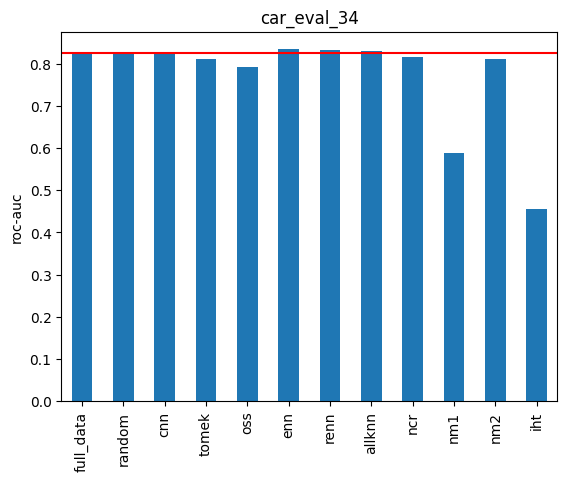

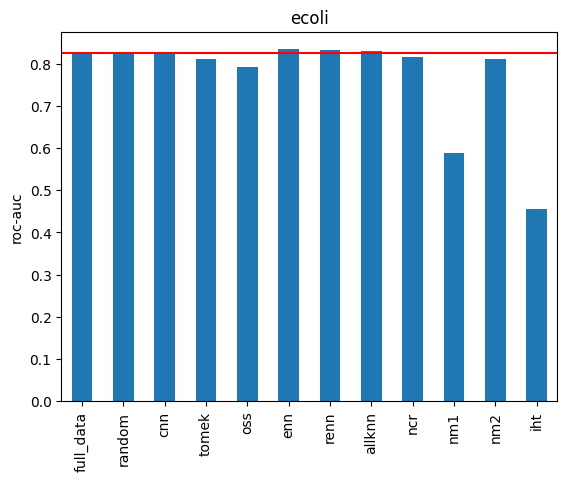

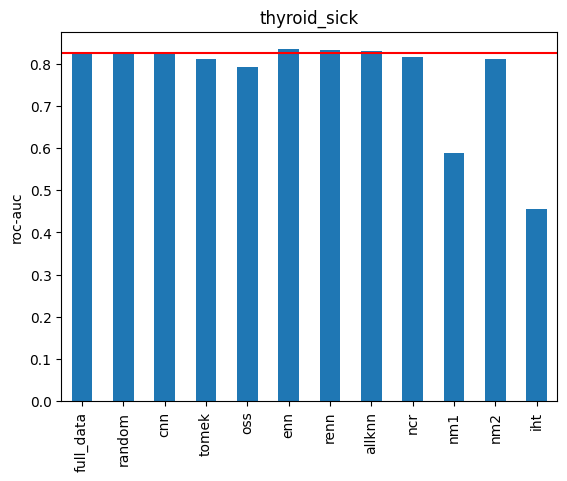

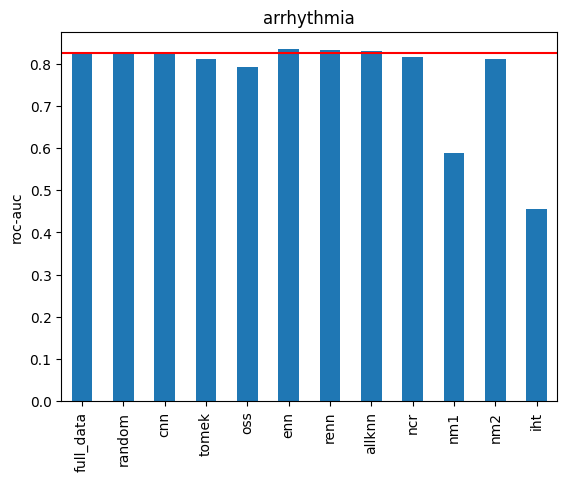

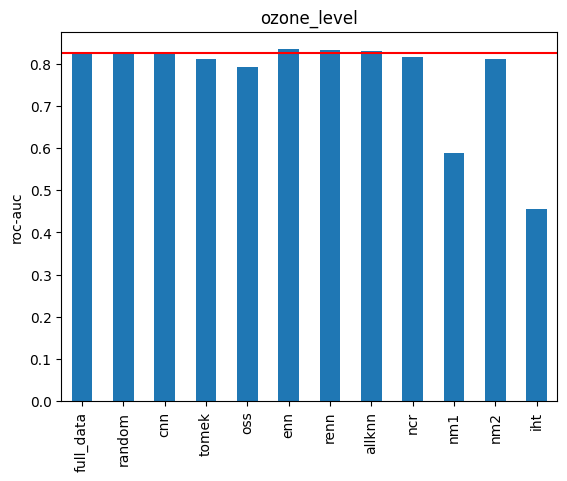

In [9]:
# print the performance of models trained with the different undersampling methods
for dataset in dataset_ls:
    pd.Series(results_dict[dataset]).plot.bar()
    plt.title(dataset)
    plt.ylabel('roc-auc')
    plt.axhline(results_dict[dataset]['full_data'], color='r')
    plt.show()

CONCLUSION: Different under-sampling techniques work best for different datasets.

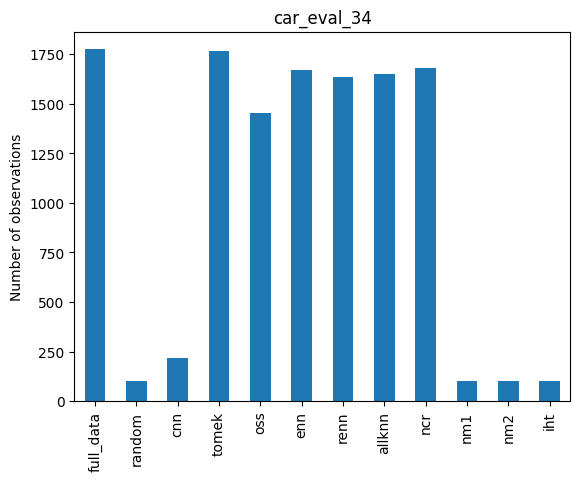

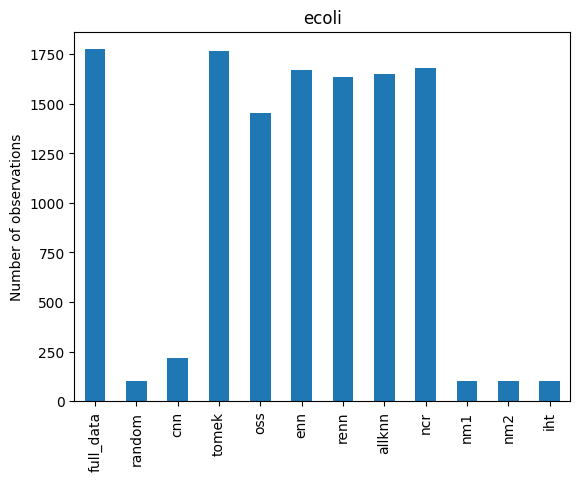

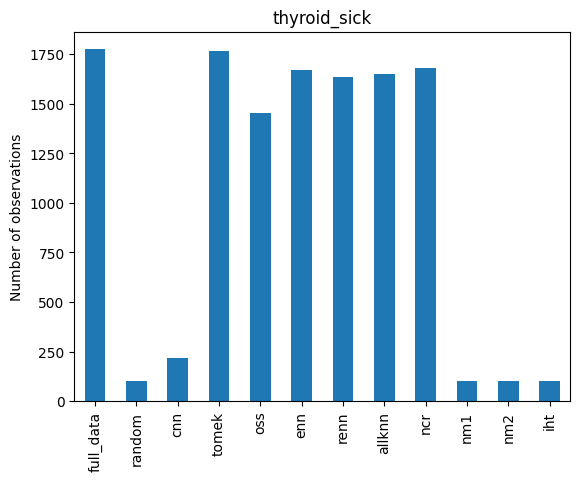

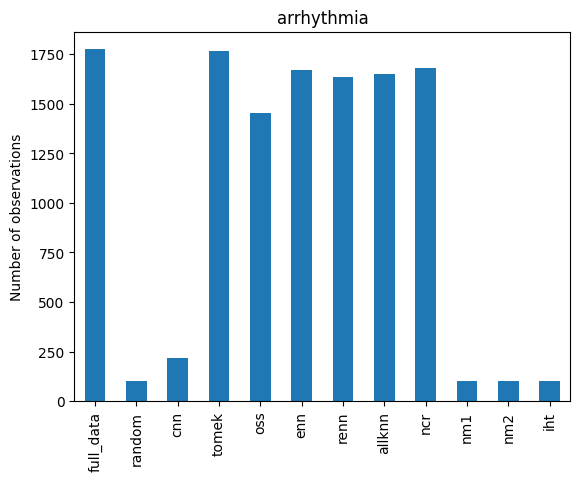

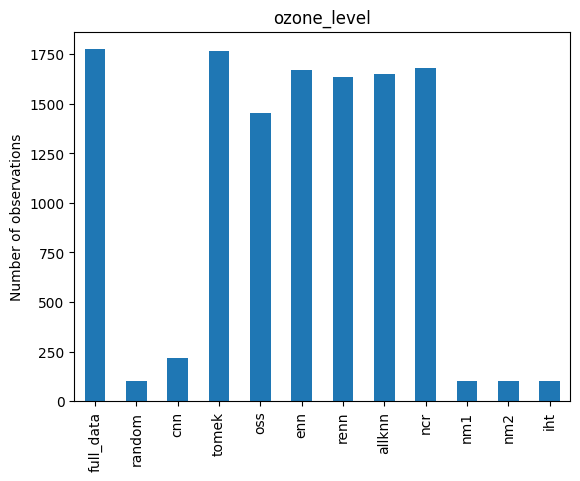

In [11]:
# To finish, I plot the shapes of the datasets after the
# different under-sampling methods were applied, for comparison

# note that the fixed methods (undersampling, near miss and
# instance hardness threshold) return the smallest datasets

# and from the cleaning methods, the Condensed nearest neighbours are 
# the more aggressive at the time of removing samples from the data

for dataset in dataset_ls:
    
    pd.Series(shapes_dict[dataset]).plot.bar()
    plt.title(dataset)
    plt.ylabel('Number of observations')
    plt.show()